# SVD Application

### Imports

In [18]:
import numpy as np
import scipy.linalg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib notebook

Let's see how to use <b>SVD</b>(Singular Value Decomposition) through the below simple exmaple.

In [7]:
A = np.array([[1,2,3,4], [2,3,4,5], [3,4,5,6]])
sep = "\n----------------"
print(A, sep)

# SVD
U, s, VT = np.linalg.svd(A)
print(U, sep)
print(s, sep)
print(VT, sep)

# reconstruct matrix
Sigma = np.zeros((A.shape[0], A.shape[1]))
min_dim = min(A.shape[0], A.shape[1])
Sigma[:min_dim, :min_dim] = np.diag(s)
print("Base Matrix:\n", U.dot(Sigma.dot(VT)))

[[1 2 3 4]
 [2 3 4 5]
 [3 4 5 6]] 
----------------
[[-0.41767294 -0.81171587  0.40824829]
 [-0.56472711 -0.12006923 -0.81649658]
 [-0.71178129  0.57157741  0.40824829]] 
----------------
[1.30111937e+01 8.41925144e-01 9.90993286e-17] 
----------------
[[-0.2830233  -0.41323283 -0.54344235 -0.67365188]
 [ 0.78733589  0.35949775 -0.0683404  -0.49617855]
 [-0.37407225  0.79697056 -0.47172438  0.04882607]
 [ 0.40008743 -0.25463292 -0.69099646  0.54554195]] 
----------------
Base Matrix:
 [[1. 2. 3. 4.]
 [2. 3. 4. 5.]
 [3. 4. 5. 6.]]


## Application1 : Compression of the color image

<IPython.core.display.Javascript object>


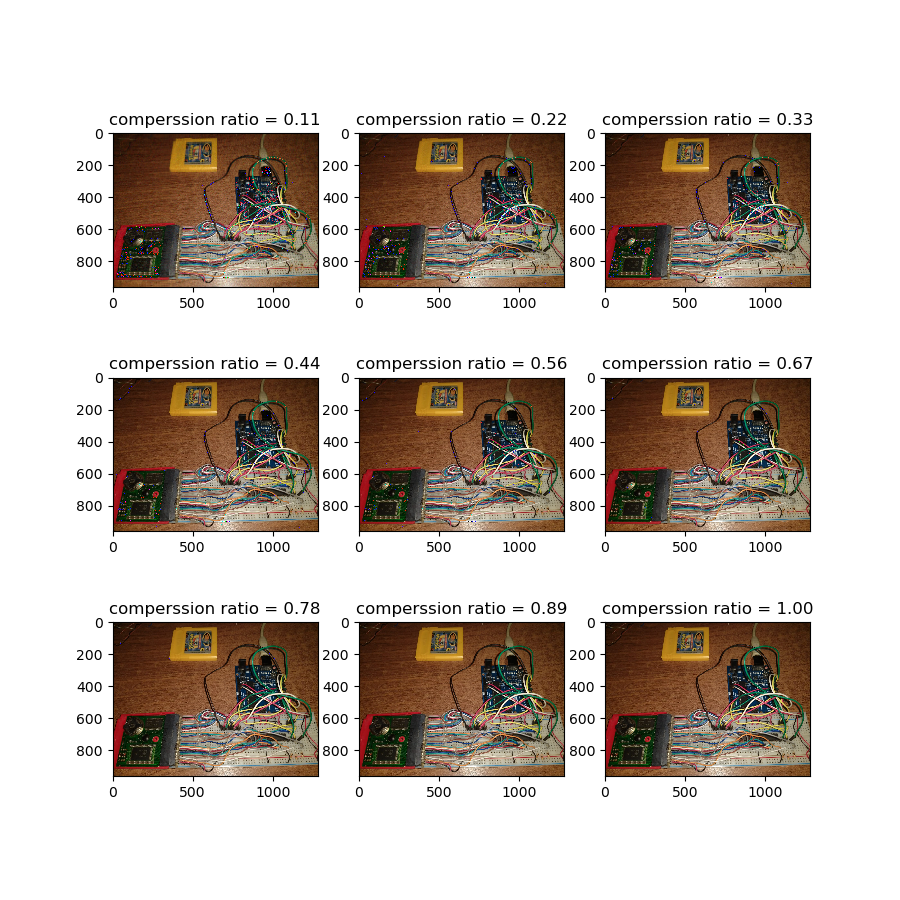

In [8]:
def load_image(image):
    im_array = np.array(image) * 255
    
    red = im_array[:, :, 0]
    green = im_array[:, :, 1]
    blue = im_array[:, :, 2]
   
    return red, green, blue

def channel_compress(color_channel, singular_value_limit):
    u, s, v = np.linalg.svd(color_channel)
    compressed = np.zeros((color_channel.shape[0], color_channel.shape[1]))
    n = singular_value_limit

    left_matrix = np.matmul(u[:, 0:n], np.diag(s)[0:n, 0:n])
    inner_compressed = np.matmul(left_matrix, v[0:n, :])
    compressed = inner_compressed.astype('uint8')
    return compressed

def compress_image(image, singular_val_lim):
    red, green, blue = load_image(image)
    compressed_red = channel_compress(red, singular_val_lim)
    compressed_green = channel_compress(green, singular_val_lim)
    compressed_blue = channel_compress(blue, singular_val_lim)
    ones = np.ones((red.shape), dtype='uint8') * 255
    
    img = np.stack((compressed_red, compressed_green, compressed_blue, ones), axis = 2)
   
    return img.tolist()

# Read Image 
img = mpimg.imread("https://user-images.githubusercontent.com/1631752/53368228-ec72d580-3926-11e9-9b7a-5208bc6ccb5e.png")
height, width = len(img), len(img[0])

# Show images according to compression ratio 
rows, cols = 3, 3
fig=plt.figure(figsize=(9, 9))

for i in range(rows * cols):
    comp_ratio = (i + 1) / rows / cols
    val_lim = int(min(width, height) * comp_ratio)
    _img = compress_image(img, val_lim)
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title("comperssion ratio = " + "{:.2f}".format(comp_ratio))
    plt.imshow(_img)

plt.show()

## Application2 : Gray Image Colorization

In [39]:
def calc_gsvd_dis(D1, D2):
    """
    D1, D2 each (m x n), (p x n) matrix, generalized svd decomposition
    D1 = U1 * Sigma1 * VT
    D2 = U2 * Sigma2 * VT
    return: dis(Sigma1, Sigma2)
    """
    # merge two matrix
    D = np.append(D1, D2, axis = 0)
    # QR decomposition
    Q, R = np.linalg.qr(D)
    Q1 = Q[:D1.shape[0]]
    Q2 = Q[D1.shape[0]:]
    # svd decomposition
    UQ1, SQ1, VQ1 = np.linalg.svd(Q1)
    
    VR = VQ1.dot(R)
    rt = np.diag(scipy.linalg.sqrtm(VR.dot(VR.T)))[:len(SQ1)]
    
    # gsvd decomposition
    Sigma1 = SQ1 * rt
    Sigma2 = (1 - SQ1 ** 2) ** 0.5 * rt
    
    return np.sum((Sigma1 - Sigma2) ** 2)

A = np.array([
    [1, 2],
    [1, 3],
    [2, 3]
])

B = np.array([
    [1, 4],
    [2, 5]
])

print(calc_gsvd_dis(A, B))

11.1163767885369


In [101]:
def load_image(image):
    im_array = image
    
    red = im_array[:, :, 0]
    green = im_array[:, :, 1]
    blue = im_array[:, :, 2]
    return (red, green, blue)

def regularize(x):
    return np.maximum(0, np.minimum(255, x)).astype('int16')

def RGBToYCbCr(img):
    r, g, b = img
    Y = 0.299 * r + 0.587 * g + 0.114 * b
    Cb = 128 - 0.168736 * r - 0.331264 * g + 0.5 * b
    Cr = 128 + 0.5 * r - 0.418688 * g - 0.081312 * b
    
    return regularize(Y), regularize(Cb), regularize(Cr)

def YCbCrToRGB(img):
    Y, Cb, Cr = img 
    r = Y + 1.402 * (Cr - 128)
    g = Y - 0.34414 * (Cb - 128) - 0.71414 * (Cr - 128)
    b = Y + 1.772 * (Cb - 128)
    
    return regularize(r), regularize(g), regularize(b)

def GrayToRGB(base_img, ref_img, block_size):
    # first create YCbCr image from the gray image
    G, _, _ = RGBToYCbCr(load_image(base_img))
    Y_g, Cb_g, Cr_g = RGBToYCbCr((G, G, G))
    
    # second convert ref_image to YCbCr image
    Y_r, Cb_r, Cr_r = RGBToYCbCr(load_image(ref_img))
    # select block from G
    height, width = G.shape
    
    def getBlock(h, hr, w, wr):
        min_dis = 1e100
        coord = None
        height, width = Y_r.shape
        for hh in range(0, height - block_size, block_size):
            for ww in range(0, width - block_size, block_size):
                dis = calc_gsvd_dis(G[h:hr, w:wr], Y_r[hh:hh + hr - h, ww:ww + wr - w])
                if min_dis > dis:
                    min_dis = dis
                    coord = (hh, ww)
        return coord
    
    for h in range(0, height, block_size):
        for w in range(0, width, block_size):
            hr = min(h + block_size, height)
            wr = min(w + block_size, width)
            hh, ww = getBlock(h, hr, w, wr)
            
            Cb_g[h:hr, w:wr] = Cb_r[hh:hh+hr-h, ww:ww+wr-w]
            Cr_g[h:hr, w:wr] = Cr_r[hh:hh+hr-h, ww:ww+wr-w]
    
    r, g, b = YCbCrToRGB((Y_g, Cb_g, Cr_g))
    
    img = np.stack((r, g, b), axis = 2).astype('uint8')
    
    return img


In [127]:
from PIL import Image
import requests
from io import BytesIO

def get_image(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return np.asarray(img)

urls = [
    'images/1.jpg',
    'images/2.jpg',
    'images/3.jpg',
    'images/4.jpg',
    'images/5.jpg'
]
# urls = [
#     "https://swall.teahub.io/photos/small/3-30522_40-beautiful-nature-wallpapers-data-id-5768-data.jpg",
#     "https://cache.desktopnexus.com/thumbseg/2374/2374392-bigthumbnail.jpg",
#     "https://www.99images.com/download-image/246276/2560x1920",
#     "https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQQev4iKr0-EL9_oKvfEZXBwwO1RsKOBE2OAQ&usqp=CAU",
#     "https://wallpaperstock.net/waterfall-grass-green-forest_wallpapers_47822_768x1024.jpg"
# ]

images = []

for url in urls:
#     images.append(get_image(url))
    images.append(np.asarray(Image.open(url)))

base_image, ref_image = images[3], images[1]
img = GrayToRGB(base_image, ref_image, 10) # base_step = [3, 5, 7, 10]
G, _, _ = RGBToYCbCr(load_image(base_image))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


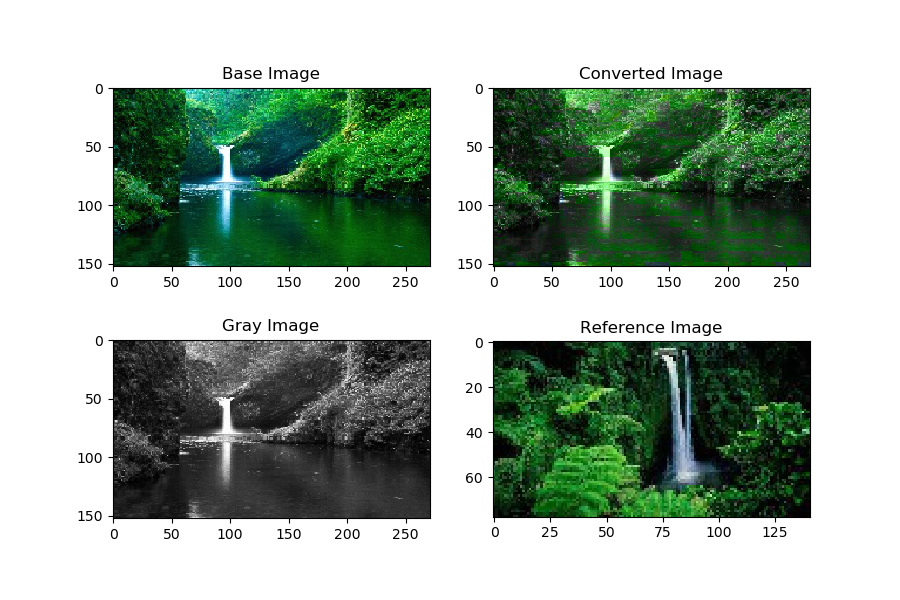

In [128]:
rows, cols = 2, 2
fig=plt.figure(figsize=(9, 6))

ax = fig.add_subplot(rows, cols, 1)
ax.set_title("Base Image")
plt.imshow(base_image)

ax = fig.add_subplot(rows, cols, 2)
ax.set_title("Converted Image")
plt.imshow(img)

ax = fig.add_subplot(rows, cols, 3)
ax.set_title("Gray Image")
plt.imshow(G, cmap='gray')

ax = fig.add_subplot(rows, cols, 4)
ax.set_title("Reference Image")
plt.imshow(ref_image)

plt.show()